## Predicting Teacher Attrition Rates for Public Schools
**This notebook explores predicting teacher attrition rates for public schools in North Carolina.** 
* Public school racial compositions are also considered when making predictions in this notebook.
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/wtubin/TeacherRetentionofNC

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [62]:
#import required Libraries
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV    
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics as mt
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import cross_validate



In [63]:
#Read in the high schools dataset - NC EA Public High Schools Dataset Feb 2018

#The 'path' variable may also be a URL pointing to the proper raw file path on github: 
#path="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv"

ML2017 = '../Machine Learning Datasets/PublicSchools2017_ML.csv'
ML2016 = '../../2016/Machine Learning Datasets/PublicSchools2016_ML.csv'
ML2015 =  '../../2015/Machine Learning Datasets/PublicSchools2015_ML.csv'
ML2014 =  '../../2014/Machine Learning Datasets/PublicSchools2014_ML.csv'

schData2017=pd.read_csv(ML2017, low_memory=False)
print('*********************************2017 ML Data*************************************')
schData2017.info()
schData2016=pd.read_csv(ML2016, low_memory=False)
print('*********************************2016 ML Data*************************************')
schData2016.info()

schData2015=pd.read_csv(ML2015, low_memory=False)
print('*********************************2015 ML Data*************************************')
schData2015.info()

schData2014=pd.read_csv(ML2014, low_memory=False)
print('*********************************2014 ML Data*************************************')
schData2014.info()

*********************************2017 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 394 entries, student_num to unit_code
dtypes: float64(350), int64(44)
memory usage: 7.4 MB
*********************************2016 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Columns: 374 entries, closed_ind to unit_code
dtypes: float64(296), int64(78)
memory usage: 6.9 MB
*********************************2015 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Columns: 403 entries, closed_ind to unit_code
dtypes: float64(342), int64(61)
memory usage: 7.5 MB
*********************************2014 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426 entries, 0 to 2425
Columns: 364 entries, closed_ind to unit_code
dtypes: float64(331), int64(

In [64]:
# Combine the data set
schData = pd.concat([schData2017,schData2016,schData2015,schData2014], axis=0, ignore_index=True)

C:\Users\yubin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [65]:
#Missing Data Threshold (Per Column)
missingThreshold = 0.60

#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 25


#Eliminate continuous columns with more than missingThreshold percentage of missing values
schoolDataRecordCt = schData.shape[0]
missingValueLimit = schoolDataRecordCt * missingThreshold
NullValueCounts = schData.isnull().sum()
NullValueCols = NullValueCounts[NullValueCounts >= missingValueLimit].index
schData = schData.drop(NullValueCols, axis=1)

#Review dataset contents after empty field drops
print('*********After: Removing columns with >= missingThreshold % of missing values******')
schData.info(verbose=False)
print ('\r\nColumns Deleted: ', len(NullValueCols))


*********After: Removing columns with >= missingThreshold % of missing values******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9756 entries, 0 to 9755
Columns: 410 entries, (TCE) prepared returns Ct 100KLT200K to wap_per_classroom
dtypes: float64(392), int64(18)
memory usage: 30.5 MB

Columns Deleted:  101


In [66]:
#Print out all the missing value rows
pd.set_option('display.max_rows', 1000)

print('\r\n*********The Remaining Missing Values Below will be set to Zero!*************************')

#Check for Missing values 
missing_values = schData.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values



*********The Remaining Missing Values Below will be set to Zero!*************************


,Variable Name,Number Missing Values
0,(TCE) prepared returns Ct 100KLT200K,4858
1,(TCE) prepared returns Ct 25KLT50K,2426
2,(TCE) prepared returns Ct 75KLT100K,2426
3,(VITA) prepared returns Ct 100KLT200K,2426
4,(VITA) prepared returns Ct 25KLT50K,2426
5,(VITA) prepared returns Ct 50KLT75K,2426
7,00_Size,2426
8,01_Size,4894
9,02_Size,2426
10,03_Size,2426


In [67]:
#Replace all remaining NaN with 0
schData = schData.fillna(0)

#Check for Missing values after final imputation 
missing_values = schData.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values

,Variable Name,Number Missing Values


### we are not remove the 0 1 year percentage for now.

In [68]:
# zeroAttrition = schData[schData['_1yr_tchr_trnovr_pct']==0.0].index
# schData = schData.drop(zeroAttrition,axis=0)
# print('*********After: Removing rows with first year turn over percentage =0.00******')
# schData.info(verbose=False)
# print ('\r\nRows Deleted: ', len(zeroAttrition))

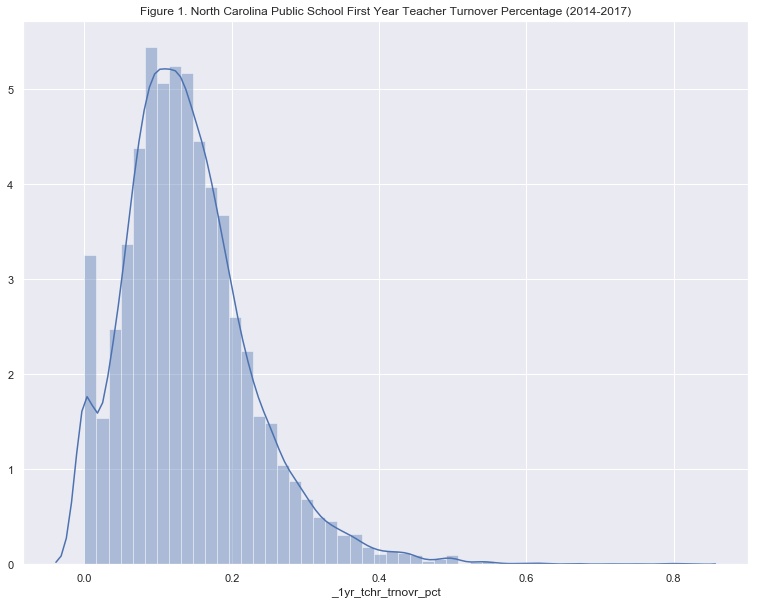

In [69]:
plt.figure(figsize=(13,10))
_1yr_tchr_trnovr_pct = schData["_1yr_tchr_trnovr_pct"]
ax = sns.distplot(_1yr_tchr_trnovr_pct);
plt.title("Figure 1. North Carolina Public School First Year Teacher Turnover Percentage (2014-2017)")
plt.show()

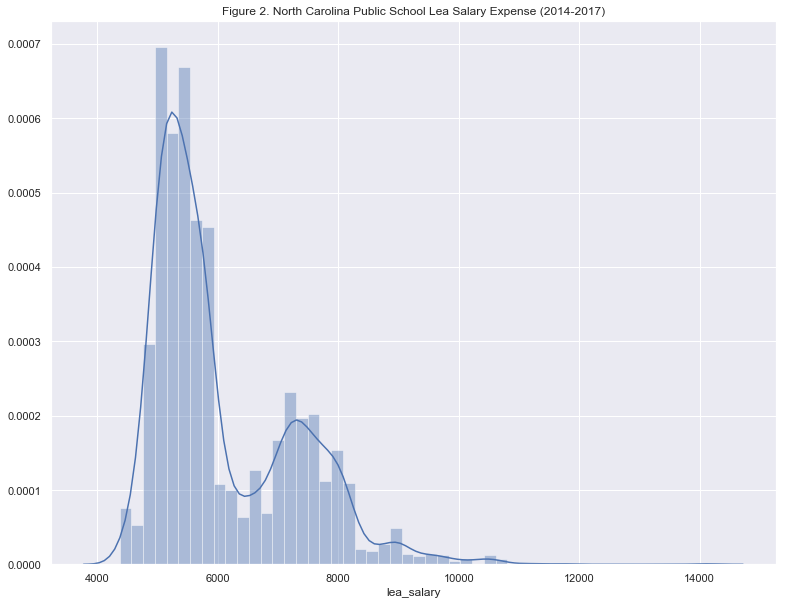

In [70]:
schData['lea_salary'] = schData['lea_total_expense_num']*schData['lea_salary_expense_pct']

plt.figure(figsize=(13,10))
lea_salary_expense_pct=schData.lea_salary_expense_pct
ax = sns.distplot(schData['lea_salary']);
plt.title("Figure 2. North Carolina Public School Lea Salary Expense (2014-2017)")
plt.show()

In [71]:
schData['_1yr_tchr_trnovr_pct'].describe()

count    9756.000000
mean        0.140861
std         0.087387
min         0.000000
25%         0.082000
50%         0.130000
75%         0.185250
max         0.818000
Name: _1yr_tchr_trnovr_pct, dtype: float64

Text(0.5,8.96,'LEA Salary Expenditure')

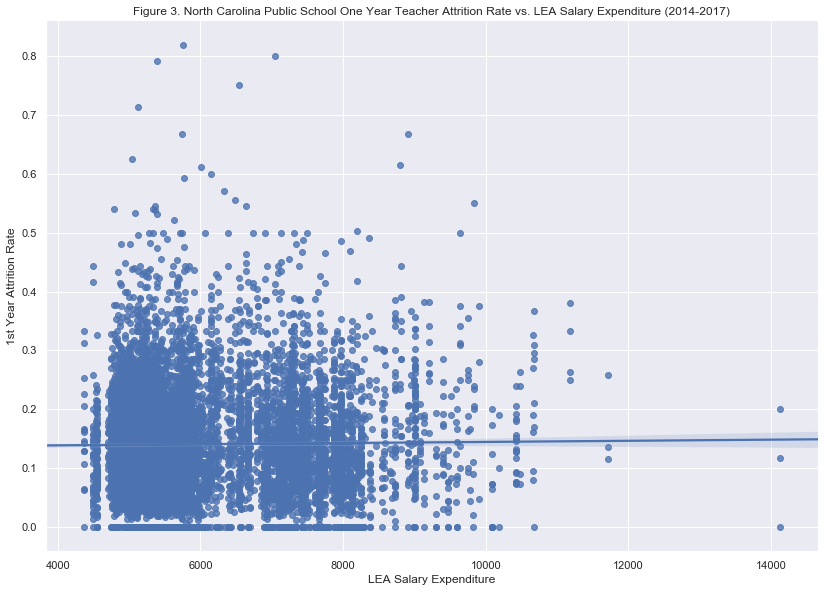

In [72]:

sns.lmplot(x="lea_salary", y="_1yr_tchr_trnovr_pct", data=schData,height=8.27, aspect=11.7/8.27)
sns.despine()

plt.title("Figure 3. North Carolina Public School One Year Teacher Attrition Rate vs. LEA Salary Expenditure (2014-2017)")
plt.ylabel('1st Year Attrition Rate')
plt.xlabel('LEA Salary Expenditure')

# plt.show()

Text(0.5,8.96,'LEA Total School Expenditure')

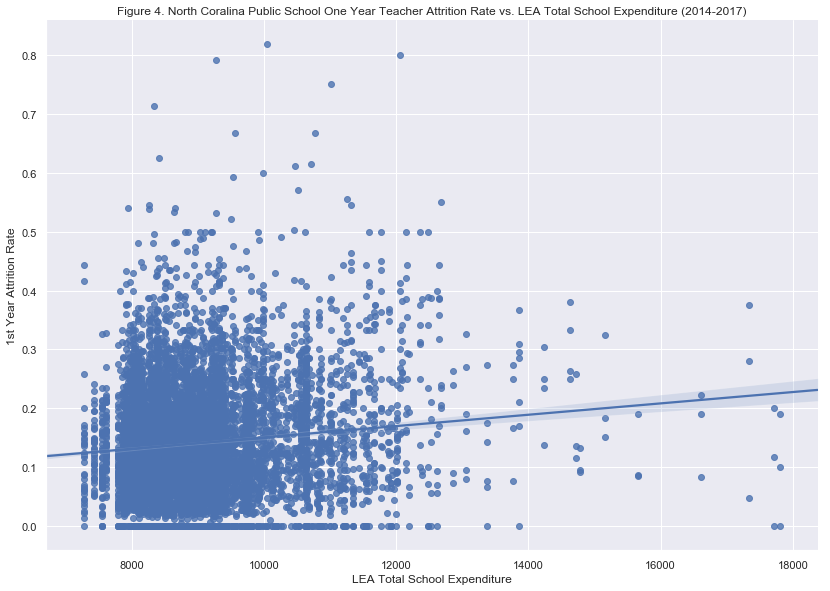

In [73]:
sns.lmplot(x="lea_total_expense_num", y="_1yr_tchr_trnovr_pct", data=schData,height=8.27, aspect=11.7/8.27)
sns.despine()

plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('1st Year Attrition Rate')
plt.xlabel('LEA Total School Expenditure')


In [74]:
#schData.select_dtypes(exclude=['object']).describe()

In [75]:
#schData.info(verbose=True)

## Feature Selection
* set max features we want to select

In [76]:
max_features =200

In [77]:
schData_bak = schData
#schData = schData_bak

In [78]:
#schData = schData_bak

In [79]:
y= schData['_1yr_tchr_trnovr_pct']
X = schData.drop(['_1yr_tchr_trnovr_pct'],axis=1)

In [80]:
#X.info(verbose=True)

### Manually remove columns

* there columns is not what we are interested in, so we remove them manaually from data set

In [81]:
X = X.drop(['st_1yr_tchr_trnovr_pct','lea_1yr_tchr_trnovr_pct'],axis=1)



In [82]:
# Feature Selection 
X_fs = X
y_fs = y


## Pearson Correlation

In [83]:
# Pearson Correlation
feature_name = X_fs.columns.tolist()
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
        # replace NaN with 0
        cor_list = [0 if np.isnan(i) else i for i in cor_list]
        # feature name
        cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-max_features:]].columns.tolist()
        # feature selection? 0 for not select, 1 for select
        cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_fs, y_fs)
print(str(len(cor_feature)), 'selected features')
print(pd.DataFrame( cor_feature))

200 selected features
                                                     0
0                       school_type_txt_Regular School
1                               lea_salary_expense_pct
2                                    EOGGr3_CACR_Black
3                           EOG/EOCSubjects_CACR_Asian
4                                    EOGGr5_CACR_Asian
5                                          SPG Grade_C
6                              EOGScienceGr5&8_GLP_SWD
7                                   Reading  SPG Score
8                           10+ Years_LEA_Exp_Pct_Prin
9                                     Math SPG Grade_D
10                             EOGMathGr3-8_CACR_Black
11                          EOGGr3_CACR_TwoorMoreRaces
12                       lea_not_highqual_class_hp_pct
13   Partnership/S-corp net income (less loss) Amt ...
14                          lea_stud_internet_comp_num
15                                         HispanicPct
16   Domestic production activities deducti

## Linear Reggesion RFE

In [84]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=max_features, step=10, verbose=5)
rfe_selector.fit(X_fs, y_fs)
rfe_support = rfe_selector.get_support()
rfe_feature = X_fs.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(pd.DataFrame(rfe_feature))

Fitting estimator with 408 features.
Fitting estimator with 398 features.
Fitting estimator with 388 features.
Fitting estimator with 378 features.
Fitting estimator with 368 features.
Fitting estimator with 358 features.
Fitting estimator with 348 features.
Fitting estimator with 338 features.
Fitting estimator with 328 features.
Fitting estimator with 318 features.
Fitting estimator with 308 features.
Fitting estimator with 298 features.
Fitting estimator with 288 features.
Fitting estimator with 278 features.
Fitting estimator with 268 features.
Fitting estimator with 258 features.
Fitting estimator with 248 features.
Fitting estimator with 238 features.
Fitting estimator with 228 features.
Fitting estimator with 218 features.
Fitting estimator with 208 features.
200 selected features
                                                     0
0                 (TCE) prepared returns Ct 100KLT200K
1                           0-3 Years_LEA_Exp_Pct_Prin
2                                   

## Linear Regression

In [85]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression

Linear = LinearRegression()

Linear_selector = SelectFromModel(Linear, threshold='1.25*median', max_features=max_features)
Linear_selector.fit(X_fs, y_fs)
Linear_support = Linear_selector.get_support()
Linear_feature = X_fs.loc[:,Linear_support].columns.tolist()
print(str(len(Linear_feature)), 'selected features')
print(pd.DataFrame(Linear_feature))

187 selected features
                                                     0
0                 (TCE) prepared returns Ct 100KLT200K
1                           0-3 Years_LEA_Exp_Pct_Prin
2                                              00_Size
3                                              01_Size
4                                              02_Size
5                                              03_Size
6                                              04_Size
7                                              05_Size
8                           10+ Years_LEA_Exp_Pct_Prin
9                          4-10 Years_LEA_Exp_Pct_Prin
10                    Accomplished_TCHR_Standard 1_Pct
11                    Accomplished_TCHR_Standard 2_Pct
12                    Accomplished_TCHR_Standard 3_Pct
13                    Accomplished_TCHR_Standard 4_Pct
14                    Accomplished_TCHR_Standard 5_Pct
15                Alternative minimum tax Amt 25KLT50K
16                   Alternative minimum ta

## Lasso

In [86]:

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

from sklearn.linear_model import Ridge

Lasso = LassoCV(cv = 5)

LassoCV_selector = SelectFromModel(Lasso, threshold='1.25*median', max_features=max_features)
LassoCV_selector.fit(X_fs, y_fs)
LassoCV_support = LassoCV_selector.get_support()
LassoCV_feature = X_fs.loc[:,LassoCV_support].columns.tolist()
print(str(len(LassoCV_feature)), 'selected features')
print(pd.DataFrame(LassoCV_feature))

200 selected features
                                                     0
0                 (TCE) prepared returns Ct 100KLT200K
1                   (TCE) prepared returns Ct 25KLT50K
2                  (TCE) prepared returns Ct 75KLT100K
3                (VITA) prepared returns Ct 100KLT200K
4                  (VITA) prepared returns Ct 25KLT50K
5                  (VITA) prepared returns Ct 50KLT75K
6                           0-3 Years_LEA_Exp_Pct_Prin
7                                              00_Size
8                                              01_Size
9                                              02_Size
10                                             03_Size
11                                             04_Size
12                                             05_Size
13                          10+ Years_LEA_Exp_Pct_Prin
14                         4-10 Years_LEA_Exp_Pct_Prin
15                    Accomplished_TCHR_Standard 1_Pct
16                    Accomplished_TCHR_Sta

## Ridge

In [87]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge

reg = Ridge()

reg_selector = SelectFromModel(reg, threshold='1.25*median', max_features=max_features)
reg_selector.fit(X_fs, y_fs)
reg_support = reg_selector.get_support()
reg_feature = X_fs.loc[:,reg_support].columns.tolist()
print(str(len(reg_feature)), 'selected features')
print(pd.DataFrame(reg_feature))

187 selected features
                                                     0
0                 (TCE) prepared returns Ct 100KLT200K
1                           0-3 Years_LEA_Exp_Pct_Prin
2                                              00_Size
3                                              01_Size
4                                              02_Size
5                                              03_Size
6                                              04_Size
7                                              05_Size
8                           10+ Years_LEA_Exp_Pct_Prin
9                          4-10 Years_LEA_Exp_Pct_Prin
10                    Accomplished_TCHR_Standard 1_Pct
11                    Accomplished_TCHR_Standard 2_Pct
12                    Accomplished_TCHR_Standard 3_Pct
13                    Accomplished_TCHR_Standard 4_Pct
14                    Accomplished_TCHR_Standard 5_Pct
15                Alternative minimum tax Amt 25KLT50K
16                Alternative minimum tax A

## Elastic Net Regression

In [88]:
from sklearn.linear_model import ElasticNet

ELN = ElasticNet()

ELN_selector = SelectFromModel(ELN, threshold='1.25*median', max_features=max_features)
ELN_selector.fit(X_fs, y_fs)
ELN_support = ELN_selector.get_support()
ELN_feature = X_fs.loc[:,ELN_support].columns.tolist()
print(str(len(ELN_feature)), 'selected features')
print(pd.DataFrame(ELN_feature))


200 selected features
                                                     0
0                 (TCE) prepared returns Ct 100KLT200K
1                   (TCE) prepared returns Ct 25KLT50K
2                  (TCE) prepared returns Ct 75KLT100K
3                (VITA) prepared returns Ct 100KLT200K
4                  (VITA) prepared returns Ct 25KLT50K
5                  (VITA) prepared returns Ct 50KLT75K
6                           0-3 Years_LEA_Exp_Pct_Prin
7                                              00_Size
8                                              01_Size
9                                              02_Size
10                                             03_Size
11                                             04_Size
12                                             05_Size
13                          10+ Years_LEA_Exp_Pct_Prin
14                         4-10 Years_LEA_Exp_Pct_Prin
15                    Accomplished_TCHR_Standard 1_Pct
16                    Accomplished_TCHR_Sta

In [89]:
## Summary
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name
                                     , 'Pearson':cor_support
                                     , 'Linear Regression':Linear_support
                                     , 'RFE':rfe_support
                                     , 'Lasso':LassoCV_support
                                     ,'Ridge':reg_support
                                     , 'Elastic Net':ELN_support
                                     
                                    })
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] ,
ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df

,Feature,Pearson,Linear Regression,RFE,Lasso,Ridge,Elastic Net,Total
1,EOGReadingGr3-8_GLP_SWD,True,True,True,True,True,True,6
2,EOGReadingGr3-8_CACR_SWD,True,True,True,True,True,True,6
3,EOGMathGr4_CACR_EDS,True,True,True,True,True,True,6
4,EOG/EOCSubjects_CACR_Hispanic,True,True,True,True,True,True,6
5,EOG/EOCSubjects_CACR_EDS,True,True,True,True,True,True,6
6,EOG/EOCSubjects_CACR_All,True,True,True,True,True,True,6
7,Does Not Meet Expected Growth_TCHR_Student Gro...,True,True,True,True,True,True,6
8,Does Not Meet Expected Growth_TCHR_Standard 6_Pct,True,True,True,True,True,True,6
9,Distinguished_TCHR_Standard 5_Pct,True,True,True,True,True,True,6
10,Distinguished_TCHR_Standard 3_Pct,True,True,True,True,True,True,6


In [90]:
# export feature selection to csv file
feature_selection_df.to_csv('Feature_Selection_Results.csv', sep=',', index=False)

In [91]:
feature_to_remove = feature_selection_df[feature_selection_df['Total']<3]['Feature']

#feature_to_remove


In [92]:
X = X.drop(feature_to_remove, axis=1)

#Review dataset contents after empty field drops
print('*********After: Removing columns not Selected by Feature Selection******')
X.info(verbose=False)
print ('\r\nColumns Deleted: ', len(feature_to_remove))

*********After: Removing columns not Selected by Feature Selection******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9756 entries, 0 to 9755
Columns: 115 entries, (TCE) prepared returns Ct 100KLT200K to tchyrs_4thru10_pct
dtypes: float64(107), int64(8)
memory usage: 8.6 MB

Columns Deleted:  293


## Transformation

In [93]:
# Transform

saved_cols = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)
#Save as data frames
X = pd.DataFrame(X)
X.columns = saved_cols


C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yubin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [94]:
# %%time

# df2_vif = pd.DataFrame()
# df2_vif["VIF Factor"] = [vif(X.values, i) for i in range(X.shape[1])]
# df2_vif["ABSVIFFactor"] = abs(df2_vif["VIF Factor"])
# df2_vif["features"] = X.columns
# df2_vif["indexes"] = range(0, len(X.columns))

In [95]:
# df2_vif = df2_vif.sort_values('ABSVIFFactor', ascending=True)
# df2_vif.to_csv('VIF_Result_ML.csv', sep=',', index=False)

In [96]:

# Create Cross Validation Object with 10 folds with 80/20 train - test split
# cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

In [97]:
# %%time



# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#     test_size=0.3,random_state =1 )

# #print("RFE CV Linear Regression 1st Pass")
# rfecvEstimator = LinearRegression()

# parameters = { 'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

# #Create a grid search object  

# grid = GridSearchCV(estimator=rfecvEstimator
#                    #, n_jobs=8 # jobs to run in parallel
#                    #, verbose=0 # low verbosity
#                    , param_grid=parameters
#                   )

# #Perform hyperparameter search to find the best combination of parameters for our data using RFECV
# grid.fit(X_train, y_train)
# print("r2 / variance : ", grid.best_score_)
# print("Residual sum of squares: %.2f"
#               % np.mean((grid.predict(X_test) - y_test) ** 2))

In [98]:
# %%time


# #print("RFE CV Linear Regression 1st Pass")
# rfecvEstimator = LinearRegression()

# parameters = { 'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]
#              }

# #Create a grid search object  
# from sklearn.model_selection import GridSearchCV
# rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
# #                    , n_jobs=8 # jobs to run in parallel
# #                    , verbose=0 # low verbosity
#                    , param_grid=parameters
#                    , cv=cv # KFolds = 10
#                    )

# #Perform hyperparameter search to find the best combination of parameters for our data using RFECV
# rfecvGridSearch.fit(X, y)

# #Use the best parameters for our RFECV Linear Regression object
# rfecvClassifierEst = rfecvGridSearch.best_estimator_

# #Recursive Feature Elimination
# rfecv = RFECV(estimator=rfecvClassifierEst, step=1, cv=cv,  verbose=1)
# X_BestFeatures = rfecv.fit_transform(X, y)

# #Print RFECV Details
# print("Ranking", rfecv.ranking_)
# print("Support", rfecv.support_)
# print("Number of Features:", rfecv.n_features_)

# #print("Linear Regression Second Pass")
# # #create a pipeline to scale all of the data and perform logistic regression during each grid search step.
# # pipe = make_pipeline(StandardScaler(), LinearRegression())

# # #Define a range of hyper parameters for grid search
# # parameters = { 'linearregression__fit_intercept':[True,False], 'LinearRegression__normalize':[True,False]
# #               , 'LinearRegression__copy_X':[True, False]
# #               , 'linearregression__n_jobs':[None]
# #              }

# # #Perform the grid search using accuracy as a metric during cross validation.
# # grid = GridSearchCV(estimator=pipe, param_grid=parameters, cv=cv)

# # #Use the best features from recursive feature elimination during the grid search
# # grid.fit(X, y)

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [99]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

## Custom Scorers for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

In [100]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score 
#from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_scorer 

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
r2_scorer = make_scorer(score_func=r2_score, greater_is_better=True) 

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer,
                'R2': r2_scorer       
               } 

## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

In [101]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')
    
    #print mean R-squared for all folds 
    R2avg = scores['test_R2'].mean()
    print_str = "The average R-Squared for all cv folds is: \t\t {R2avg:.5}"
    print(print_str.format(R2avg=R2avg))
    print('*********************************************************')


    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['R2'] = scores['test_R2']
    return scoresResults


## Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with graduation rate predictions clipped 0% and 100%. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [102]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [103]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False),'normalize': (True, False),}

#Create a grid search object using the  
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
            normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [104]:
#Print the parameterization of the best estimator
regGridSearch.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
            normalize=True)

## Baseline Regression Model - Cross Validation
**Perform tenfold cross validation using the grid search "best" parameters and our Capped Linear Regression estimator**
* 10-fold cross-validation using the parameters for the top performing model 
* CAP predictions between 0 and 100% 
* Evaluate cross-validation results using MAE, MAPE, and RMSE

In [105]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
baseLine_Results = EvaluateRegressionEstimator(regEstimator, X, y, cv)


The average MAE for all cv folds is: 			 0.05324
The average MAE percentage (MAPE) for all cv folds is: 	 46.878
The average RMSE for all cv folds is: 			 0.071054
*********************************************************
The average R-Squared for all cv folds is: 		 0.30754
*********************************************************
Cross Validation Fold Mean Error Scores


In [106]:
baseLine_Results

,MAE,MAPE,RMSE,R2
0,0.055864,47.707090,0.074200,0.311427
1,0.051125,45.913760,0.066644,0.354253
2,0.053868,46.790677,0.072483,0.250469
3,0.056127,47.251894,0.075571,0.339946
4,0.052464,49.030515,0.072769,0.313954
5,0.052272,43.636428,0.069931,0.247460
6,0.053605,47.544824,0.071585,0.332481
7,0.051797,44.440848,0.068542,0.279025
8,0.053234,49.177820,0.068993,0.318034
9,0.052040,47.286925,0.069824,0.328355


## Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [107]:
# #Create a Linear regression object and perform a grid search to find the best parameters
# from sklearn.svm import SVR
# reg = SVR()

# #Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
# costs = [0.001, 0.1]
# defGamma = 1 / X.shape[1]  #This is the default value for the gamma parameter
# gammas = [defGamma, 0.1]
# kernels = ['rbf','linear']
# parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

# #Create a grid search object using the parameters above
# from sklearn.model_selection import GridSearchCV
# regGridSearch = GridSearchCV(estimator=reg
#                    , n_jobs=8 # jobs to run in parallel
#                    , verbose=1 # low verbosity
#                    , param_grid=parameters
#                    , cv=cv # KFolds = 10
#                    , scoring=mae_scorer)

# #Perform hyperparameter search to find the best combination of parameters for our data
# regGridSearch.fit(X, y)

In [108]:
#Display the best estimator parameters
regGridSearch.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
            normalize=True)

In [109]:
# from sklearn.svm import SVR

# #Create a regression estimator with best parameters for cross validation
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# #Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
# EvaluateRegressionEstimator(regEstimator, X_highSchools, Y, cv)

In [110]:
#Do we predict graduation rates greater than 100%?
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# regEstimator.fit(X_highSchools, Y)
# yhat = regEstimator.predict(X_highSchools)
# print("Yhat Max: ", yhat.max())

## Graduation Rate - Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [111]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [112]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

In [113]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Lasso_Results = EvaluateRegressionEstimator(regEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.064694
The average MAE percentage (MAPE) for all cv folds is: 	 61.813
The average RMSE for all cv folds is: 			 0.085483
*********************************************************
The average R-Squared for all cv folds is: 		 -0.00042389
*********************************************************
Cross Validation Fold Mean Error Scores


In [114]:
#Do we predict graduation rates greater than 100%?
regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, positive=False, precompute=True, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=True)

regEstimator.fit(X, y)
yhat = regEstimator.predict(X)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.14086080360803607


## Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [115]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   38.6s
[Parallel(n_jobs=8)]: Done 345 out of 360 | elapsed:   43.0s remaining:    1.8s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   47.1s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [116]:
#Display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, random_state=0, solver='sparse_cg', tol=0.0001)

In [117]:
%%time
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Ridge_Results = EvaluateRegressionEstimator(regEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.053281
The average MAE percentage (MAPE) for all cv folds is: 	 46.883
The average RMSE for all cv folds is: 			 0.071063
*********************************************************
The average R-Squared for all cv folds is: 		 0.30738
*********************************************************
Cross Validation Fold Mean Error Scores
Wall time: 985 ms


In [118]:
#Do we predict graduation rates greater than 100%?
regEstimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, random_state=0, solver='saga', tol=0.0001)

regEstimator.fit(X, y)
yhat = regEstimator.predict(X)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.4415953264064493


## Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [119]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

reg = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:    8.7s
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:    9.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'alpha': [0.001, 0.1, 1, 10], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [120]:
#Display the best estimator parameters
regGridSearch.best_estimator_

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.001,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=True)

In [121]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
elastic_Results = EvaluateRegressionEstimator(regEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.057094
The average MAE percentage (MAPE) for all cv folds is: 	 52.691
The average RMSE for all cv folds is: 			 0.075814
*********************************************************
The average R-Squared for all cv folds is: 		 0.21271
*********************************************************
Cross Validation Fold Mean Error Scores


In [122]:
#Do we predict graduation rates greater than 100%?
regEstimator =  regGridSearch.best_estimator_

regEstimator.fit(X, y)
yhat = regEstimator.predict(X)
print("Yhat Max: ", yhat.max())

Yhat Max:  0.2675953227207436
